# Top trending words in Twitter


## Q2 Get trending Topics in twitter right now:

    - Find the word from the tweet which is occurring most number of the times in the whole tweets corpus.
    - Top 10 trending topic.


In [1]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn # For plotting
import time

from IPython import display  # To work with graphs on jupyter
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
from collections import namedtuple #function for creating tuple subclasses with named fields

In [2]:
# magic function to plot inline
%matplotlib inline

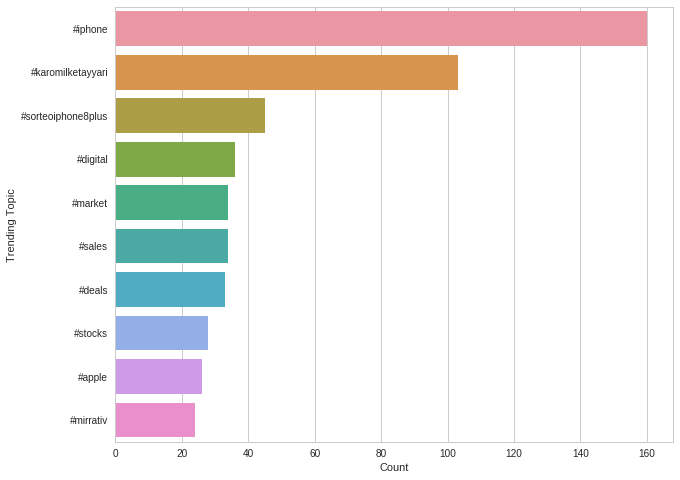

Stoping the program


In [3]:
if __name__ == "__main__":

    sc = SparkContext(appName="TrendingTopics")  # Start sparkcontext
    ssc = StreamingContext(sc, 60 * 60)  # Setting 1hr streaming interval
    sqlContext = SQLContext(sc)  # Sql context for running sql query
    
    # Host port of server which is sending text stream
    host = "localhost"
    port = 8878
    socketStream = ssc.socketTextStream(host, port) # Connecting to socket
    dStream = socketStream.window(60 * 60)  # Setting 1hr window

    fields = ("Hash", "count")
    Tweet = namedtuple('Tweet', fields)
    
    # DStream where all the computation is done
    (dStream.flatMap(lambda text: text.split(" "))\
          .filter(lambda word: word.lower().startswith("#"))\
          .map(lambda word: (word.lower(), 1))\
          .reduceByKey(lambda a, b: a + b)\
          .map(lambda rec: Tweet(rec[0], rec[1]))\
          .foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))\
                      .limit(10).registerTempTable("tweets")))
    
    # Start the streamer, make sure to stop it
    ssc.start()
#     ssc.awaitTermination()

    while True:  # Display graph here
        try:
            time.sleep(60 * 60)  # Sleep 1hr, plot graph every hour
            topics = sqlContext.sql('Select Hash, count from tweets')
            topics = topics.toPandas()
            display.clear_output(wait=True)
            sn.set_style("whitegrid")  # Styling of plot
            sn.plt.figure(figsize = (10, 8)) # Figuresize of plot
            ax = sn.barplot(x="count", y="Hash", data=topics, estimator=sum)
            ax.set(xlabel='Count', ylabel='Trending Topic') # Labeling of plot
            sn.plt.show()
        except KeyboardInterrupt:  # User interrupt
            ssc.stop()
            print("Stoping the program")
            break
        # Continue even if there is exception and stop only on Keyboard Interrupt
        except Exception as e:  
            print(e)
            continue
